Start with a simple multi-stage autoencoder.

Use pRELU since it should be invertible

https://blog.keras.io/building-autoencoders-in-keras.html

Use MonotonicPReLU and use double-negation to reuse forward M...PReLU layers in inverted phase without needing a new class. 

Force Inverse Dense layers to stay Penrose pseudo-inverse of base Dense layers.

Use Tensorflow pseudo-inverse operator directly across base -> inverse layer. Very slow.


In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.python.ops import nn
import keras
from keras import layers
from keras.datasets import mnist


In [2]:

(x_train, _), (x_test, _) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)


(60000, 784)
(10000, 784)


In [3]:
!pip install -v -U git+https://github.com/LanceNorskog/keras-invertible.git
from keras_invertible import InvertedActivation, InvertedDensePI, InvertedLeakyReLU, InvertedBias, MonotonicPReLU

Using pip 21.1.3 from /usr/local/lib/python3.7/dist-packages/pip (python 3.7)
Value for scheme.platlib does not match. Please report this to <https://github.com/pypa/pip/issues/9617>
distutils: /usr/local/lib/python3.7/dist-packages
sysconfig: /usr/lib/python3.7/site-packages
Value for scheme.purelib does not match. Please report this to <https://github.com/pypa/pip/issues/9617>
distutils: /usr/local/lib/python3.7/dist-packages
sysconfig: /usr/lib/python3.7/site-packages
Value for scheme.headers does not match. Please report this to <https://github.com/pypa/pip/issues/9617>
distutils: /usr/local/include/python3.7/UNKNOWN
sysconfig: /usr/include/python3.7m/UNKNOWN
Value for scheme.scripts does not match. Please report this to <https://github.com/pypa/pip/issues/9617>
distutils: /usr/local/bin
sysconfig: /usr/bin
Value for scheme.data does not match. Please report this to <https://github.com/pypa/pip/issues/9617>
distutils: /usr/local
sysconfig: /usr
Additional context:
user = False
home

In [4]:
kernel_init='glorot_uniform'

def create_palindromic_model():
    input_img = keras.Input(shape=(784,))
    a = layers.Dense(128, kernel_initializer=kernel_init, name='a')
    x = a(input_img)
    a_relu = MonotonicPReLU()
    x = a_relu(x)
    x = layers.Dropout(0.2)(x)
    b = layers.Dense(64, kernel_initializer=kernel_init, name='b')
    x = b(x)
    b_relu = MonotonicPReLU()
    x = b_relu(x)
    c = layers.Dense(48, kernel_initializer=kernel_init, name='c')
    x = c(x)
    c_relu = MonotonicPReLU()
    x = c_relu(x)

    x = InvertedActivation()(x)
    x = c_relu(x)
    x = InvertedActivation()(x)
    x = InvertedDensePI(c, name='pi_c')(x)
    x = InvertedActivation()(x)
    x = b_relu(x)
    x = InvertedActivation()(x)
    x = InvertedDensePI(b, name='pi_b')(x)
    x = InvertedActivation()(x)
    x = a_relu(x)
    x = InvertedActivation()(x)
    x = InvertedDensePI(a, name='pi_a')(x)

    autoencoder = keras.Model(input_img, x)
    autoencoder.compile(optimizer='adam', loss='mse')
    autoencoder.summary()
    return autoencoder

In [5]:
num_epochs =  1000  # @param {type: "slider", min:2, max:1000}
autoencoder = create_palindromic_model()
early_stopping = tf.keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True)

autoencoder.fit(x_train, x_train,
                epochs=num_epochs,
                batch_size=2048,
                shuffle=True,
                callbacks=[early_stopping],
                validation_data=(x_test, x_test))


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 784)]        0           []                               
                                                                                                  
 a (Dense)                      (None, 128)          100480      ['input_1[0][0]']                
                                                                                                  
 monotonic_p_re_lu (MonotonicPR  (None, 128)         128         ['a[0][0]',                      
 eLU)                                                             'inverted_activation_4[0][0]']  
                                                                                                  
 dropout (Dropout)              (None, 128)          0           ['monotonic_p_re_lu[0][0]']  

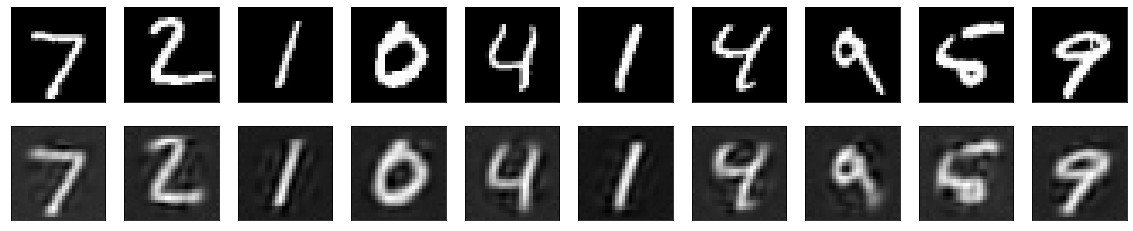

In [6]:
# Use Matplotlib (don't ask)
import matplotlib.pyplot as plt

predicted_imgs = autoencoder.predict(x_test)

n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(predicted_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()


In [7]:
def get_pair(model, base, pi_base):
    for layer in model.layers:
        if layer.name == base:
            dense = layer
        elif layer.name == pi_base:
            pi_dense = layer
        
    weights = dense.get_weights()
    print(len(weights))
    W = weights[0]
    print(type(W))
    print('W.shape', W.shape)
    # print('b.shape', b.shape)
    inv_weights = pi_dense.W.numpy()
    print('inv_W.shape', inv_weights.shape)
    return np.asarray(W, dtype='float64'), np.asarray(inv_weights, dtype='float64')


In [8]:
def delta_gram(gram):
    print(gram.shape)
    ident = np.eye(gram.shape[0])
    return np.mean(np.abs(gram - ident))

def plot_gram(gram):
    fig, ax = plt.subplots()
    im = ax.imshow(gram)


2
<class 'numpy.ndarray'>
W.shape (784, 128)
inv_W.shape (128, 784)
(128, 128)
0.16666583476098784
-1.625338661276946e-33


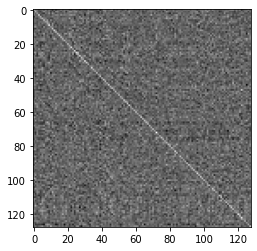

In [9]:
(a, inv_a) = get_pair(autoencoder, 'a', 'pi_a')
gram = np.matmul(inv_a, a)
print(delta_gram(gram))
print(np.linalg.det(gram))
plot_gram(gram)


2
<class 'numpy.ndarray'>
W.shape (128, 64)
inv_W.shape (64, 128)
(64, 64)
0.11456783362115888
6.262769627538441e-09


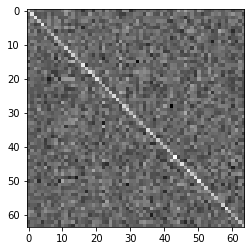

In [10]:
(b, inv_b) = get_pair(autoencoder, 'b', 'pi_b')
gram = np.matmul(inv_b, b)
print(delta_gram(gram))
print(np.linalg.det(gram))
plot_gram(gram)

2
<class 'numpy.ndarray'>
W.shape (64, 48)
inv_W.shape (48, 64)
(48, 48)
0.1929087130961157
6858.476146080482


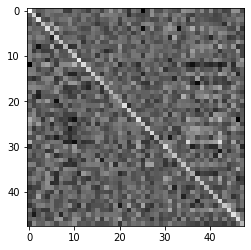

In [11]:
(c, inv_c) = get_pair(autoencoder, 'c', 'pi_c')
gram = np.matmul(inv_c, c)
print(delta_gram(gram))
print(np.linalg.det(gram))
plot_gram(gram)